Let's first import the dataset we produced [here](../data.ipynb)

In [4]:
import pickle 

with open('../Caenorhabditis_elegans_dataset.pkl', 'rb') as file: 
    df = pickle.load(file)

df.head()

,compound_name,dosage,fingerprint,avg_lifespan_change_percent
0,(R)-2-hydroxyglutarate,8 mM,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",42.90
1,"(R,R)-cis-Diethyl tetrahydro-2,8-chrysenediol",33 µM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.00
2,(S)-2-hydroxyglutarate,8 mM,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",31.80
3,"1,2,4-triazolo[1,5-a]pyridine",500 nM,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",12.00
4,"1,7-dimethylxanthine",50 µg/mL,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.75


For now, let's consider only the ECFP in our training set 

In [5]:
import numpy as np

# Convert fingerprint lists into NumPy array for ML compatibility
X = np.array(df['fingerprint'].tolist())

# Use lifespan change as the target variable
y = df['avg_lifespan_change_percent'].values

print(X.shape)
print(y.shape)

(516, 2048)
(516,)


for conformal predicition, I have to reserve a few data points for calibration set too, so we can do a split as follows: 

Training Set (80%): 319 data points

Calibration Set (10%): 68 data points

Test Set (10%): 69 data points

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.regression import SplitCP

# First, split into training and temporary (calibration + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the temporary set into calibration and test sets
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, 
                                 max_depth=10, min_samples_split=5, min_samples_leaf=4)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Create the predictor to wrap the trained model
rf_predictor = BasePredictor(rf_model, is_trained=True)

# Instantiate the SplitCP model with the RandomForest predictor
split_cp = SplitCP(rf_predictor)

# Fit the conformal predictor using the fitting and calibration data
# Here, we are using `X_calib` (calibration data) and `y_calib` (calibration target)
split_cp.fit(X_fit=X_train, y_fit=y_train, X_calib=X_calib, y_calib=y_calib)

# Now, make predictions using the test set, take alpha = 0.05 for only make predictions within 95% confidence interval
alpha = 0.1
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

# Check the predictions and intervals
print("Predictions:", y_pred)
print("Lower bounds:", y_pred_lower)
print("Upper bounds:", y_pred_upper)


Predictions: [ 9.20410692 12.03145677 16.83236938 14.12877202 18.36973735 13.55282149
 14.99370548  8.9103983  19.09433068 17.23286524 10.53770435 14.73353951
 14.27848867 14.87971408 15.32547238 13.28781641 12.86451014 14.72614892
 17.79470508  9.07855091 10.26582804 12.24129807  8.9950436  14.94292222
 21.79141293 16.56124634 17.14564926 14.34750565 13.18620617 15.85458845
 15.92707132  8.86682823 18.79379313 19.67532318 13.58399572 14.41845404
 14.23231712 22.00858449 15.68688603 16.30745439 21.6856705  11.98749197
  4.47023663 10.99149924  7.31968504 12.7202007  19.34656596 15.68688603
 16.26486679 20.94577111 15.34392016 12.98679101]
Lower bounds: [-18.16191879 -15.33456894 -10.53365634 -13.23725369  -8.99628837
 -13.81320422 -12.37232023 -18.45562741  -8.27169503 -10.13316047
 -16.82832136 -12.63248621 -13.08753705 -12.48631163 -12.04055334
 -14.07820931 -14.50151557 -12.6398768   -9.57132063 -18.2874748
 -17.10019767 -15.12472765 -18.37098211 -12.4231035   -5.57461279
 -10.80477

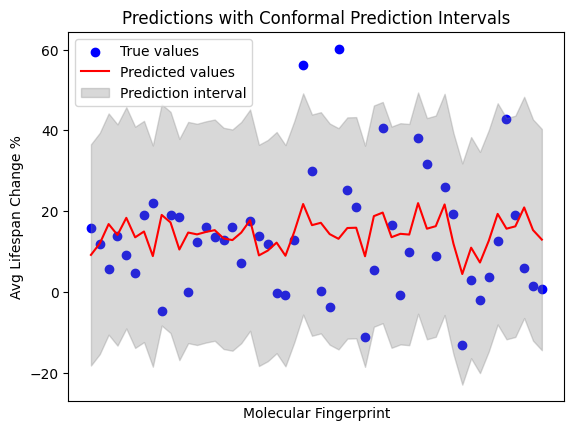

In [10]:
import matplotlib.pyplot as plt

# Scatter plot for actual values
plt.scatter(range(len(y_test)), y_test, color='blue', label='True values')

# Plot predicted values
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted values')

# Plot lower and upper prediction intervals
plt.fill_between(range(len(y_pred)), y_pred_lower, y_pred_upper, color='gray', alpha=0.3, label='Prediction interval')

# Set x-axis labels (custom ticks)
plt.xticks([], [])

# Labels and title
plt.xlabel('Molecular Fingerprint')
plt.ylabel('Avg Lifespan Change %')
plt.title('Predictions with Conformal Prediction Intervals')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [12]:
# Compute the percentage of true values inside the prediction intervals
coverage = np.mean((y_test >= y_pred_lower) & (y_test <= y_pred_upper))
print(f"Prediction interval coverage: {coverage * 100:.2f}%")


Prediction interval coverage: 91.30%


In [13]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")


Mean Absolute Error: 14.22


In [14]:
abstention_percentage = np.mean((y_test < y_pred_lower) | (y_test > y_pred_upper))
print(f"Abstention percentage: {abstention_percentage * 100:.2f}%")


Abstention percentage: 8.70%
